In [ ]:
    Generate figures to help understand the calibration document

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [3]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

dirName = "/Users/mfisherlevine/Desktop/CBP_poking"

import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False


/Users/mfisherlevine/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
# pixel coordinates
ib = np.linspace(-1, 1, 5000)

# true per-pixel sensitivity variation (assuming all pixels are the same size)
nPerCCD = len(ib)//4      # we have 4 chips in the following S_qe prescription
S_qe = 0.98*np.where(ib < -0.5,         0.90 - 0.1*(ib + 0.5), 
                     np.where(ib < 0,   0.95 + 0.05*ib,
                     np.where(ib < 0.5, 0.85 - 0.1*(ib - 0.5), 
                                        0.87 + 0.05*ib)))

# additive part of flat field screen illumination
i = 0.05*ib**2

# additive term
# MFL changed amplitude so that it's not identical to -i at boundaries --> doesn't cancel perfectly
ghost_phase = 0
ghost_freq = 2.
A = -0.07*np.cos(ghost_freq*ib*np.pi+ghost_phase)

# optical distortion
# MFL changed the sign
S_optical = 1 + 0.1*ib**4

# MFL changed to higher freq than CBP sampling
# and made non-commensurate with all other pitches
S_ccd = 1 + 0.01*np.sin(50*ib*np.pi) 
# S_ccd = np.ones_like(ib)#+ 0.01*np.sin(50*ib*np.pi) 

# sensitivity allowing for pixel size variation
calS = S_qe*S_optical*S_ccd
# measured flat field
Fb = (1 + i + A)*calS

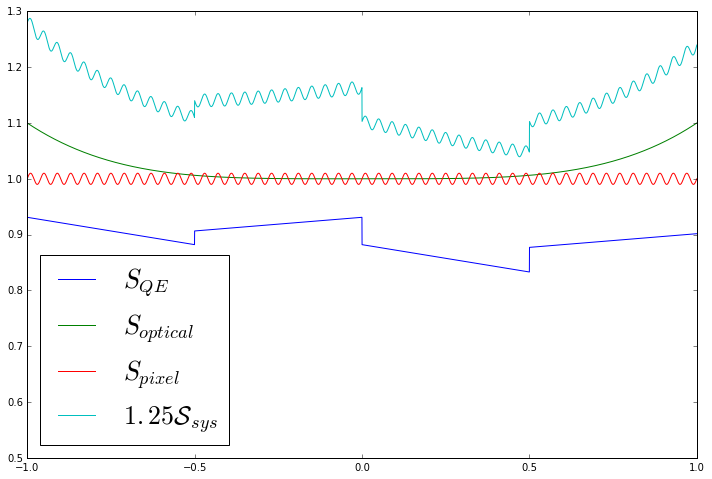

In [6]:
plt.figure(figsize=(12,8))
plt.plot(ib, S_qe, label='$S_{QE}$')
plt.plot(ib, S_optical, label='$S_{optical}$')
plt.plot(ib, S_ccd, label='$S_{pixel}$')

# plt.plot(ib, 1.3*Fb, label='$Fb$')

scale=1.25
plt.plot(ib, scale*calS, label='$%g{\cal S}_{sys}$' % scale)

plt.legend(loc='best', fontsize=26).draggable()
foo = plt.ylim(0.5, 1.3)

plt.savefig(os.path.join(dirName, "S.pdf"))

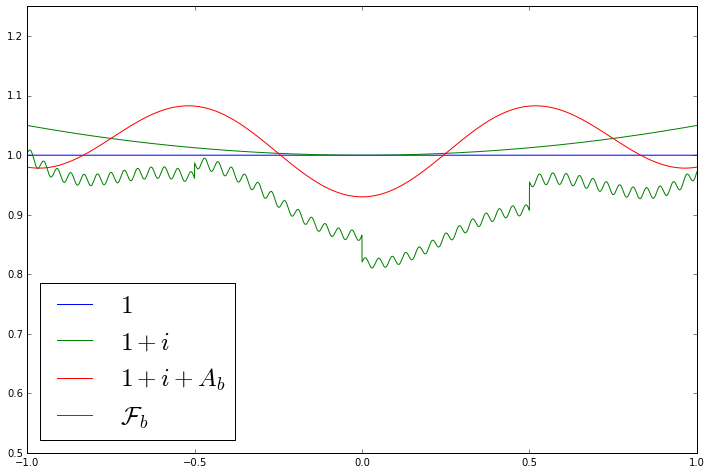

In [7]:
plt.figure(figsize=(12,8))

plt.plot(ib, np.ones_like(ib), label='$1$')
plt.plot(ib, 1 + i, label='$1 + i$')
# plt.plot(ib, 1 + A, label='$1 + A$')
plt.plot(ib, 1 + i + A, label='$1 + i + A_b$')
if False:
    scale = 1.3
    plt.plot(ib, scale*calS, label='$%g{\cal S}_b$' % scale)

plt.plot(ib, Fb, 'g-', label='${\cal F}_b$')

plt.legend(loc='best', fontsize=25).draggable()
foo = plt.ylim(0.5, 1.25)

plt.savefig(os.path.join(dirName, "F_b.png"))

In [9]:
import scipy; print scipy.version.version
from scipy import interpolate

0.18.1


In [49]:
print calS[samples][0]
print calS[samples][-1]


1.01154244665
0.962820339645


1.00017893459
Ringing = 1.634 / 1000
Max val = 0.179 / 1000


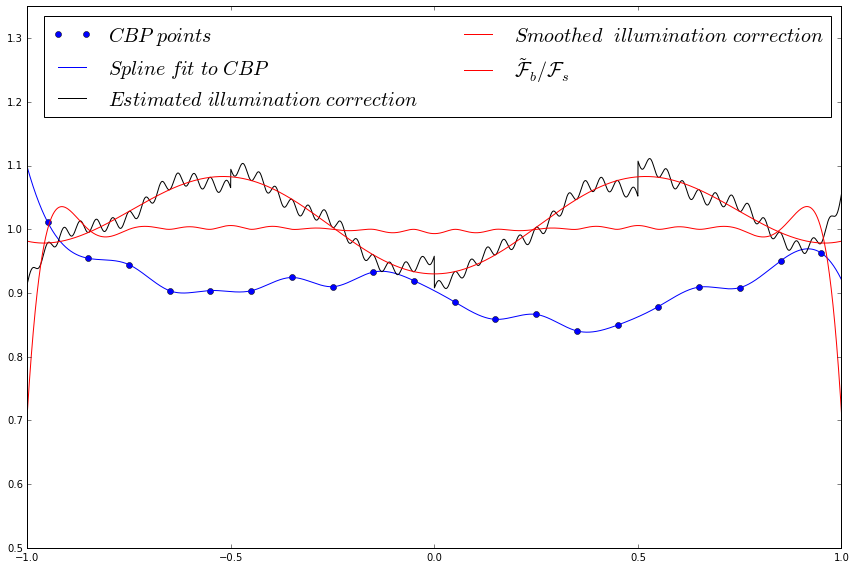

In [83]:
from scipy import interpolate

nSampleCBP = 5            # number of CBP spots per chip
plot = True

bc_type = 'not-a-knot'
# bc_type = 'natural'
# bc_type = 'clamped'


samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data
# interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
interpCalS = interpolate.CubicSpline(ib[samples], calS[samples], bc_type=bc_type)  # spline fit to CBP data
rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination


# interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
interpIllum = interpolate.CubicSpline(ib[samples], rawEstIllum[samples], bc_type=bc_type)


estCalS = Fb/interpIllum(ib)
residual = estCalS/calS

peak_to_peak = np.max(residual) - np.min(residual)
maxval = np.max(residual)
print maxval

print 'Ringing = %.3f / 1000' %(peak_to_peak*1000)
print 'Max val = %.3f / 1000' %(1000*maxval-1000)
res_multiplier = 200

if plot:
    plt.figure(figsize=(12,8))
#     plt.plot(ib, Fb, 'g-',  label='$Flat\endash field \ screen$')
    plt.plot(ib[samples], calS[samples], 'bo', label=r'$CBP \ points$')
    plt.plot(ib, interpCalS(ib), 'b-', label=r'$Spline \ fit \ to \ CBP$')
    plt.plot(ib, rawEstIllum, 'k-', label='$Estimated \ illumination \ correction$')
    plt.plot(ib, interpIllum(ib), 'r-', label='$Smoothed \ \ illumination \ correction$')
#     plt.plot(ib, calS + 0.3, 'y-')
#     plt.plot(ib, estCalS + 0.3, 'm-', label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')
    plt.plot(ib, res_multiplier*residual-res_multiplier+1, 'r-', label=r'$\tilde{\cal F}_b/{\cal F}_s$')

    plt.legend(loc='best',  fontsize=20, ncol=2)
    foo = plt.ylim(0.5, 1.35)
    plt.tight_layout()
    plt.savefig(os.path.join(dirName, "CBP_4.png"))

Max residual in range = 1.00017893459
Max residual in range = 1.00002981896


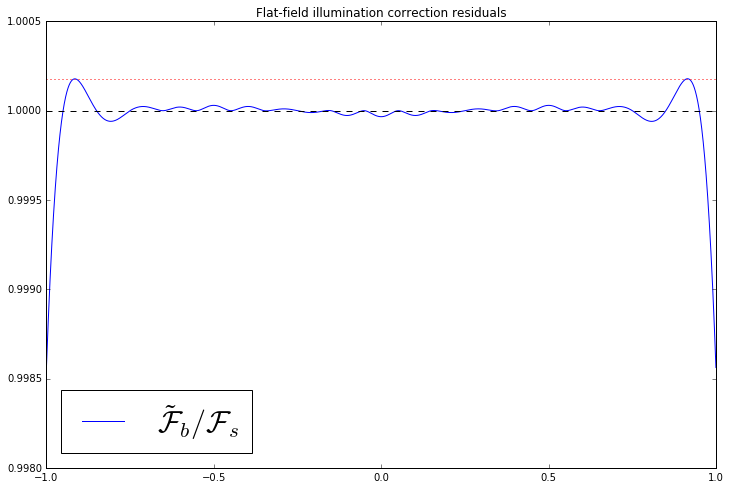

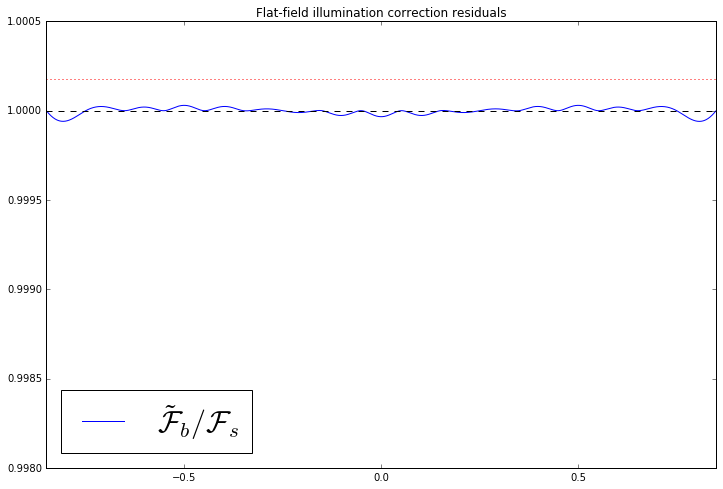

In [22]:
for xy_clip in [1, 0.85]:
    plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    residual = estCalS/calS

    npts = len(ib)
    index_min = int(((1.-xy_clip)/2.) * npts)
    index_max = npts - index_min

    print 'Max residual in range = %s' % np.max(residual[index_min:index_max])

    plt.plot(ib[index_min:index_max], residual[index_min:index_max], label=r'$\tilde{\cal F}_b/{\cal F}_s$')
    plt.axhline(1.0, color='k', ls='--')
    maxval = np.max(estCalS/calS)
    plt.axhline(maxval, color='r', ls=':')

    _ = plt.title(r'Flat-field illumination correction residuals')
#     ticks = list(ax.get_yticks())#.append(maxval)
#     ticks = [np.round(_,4) for _ in ax.get_yticks()]
#     ticks.append(np.round(maxval,5))
#     ax.set_yticks(ticks)
#     plt.ylim(0.998,1.0005)
    plt.legend(loc='best',  fontsize=30)
    # plt.xlim(-.85,.85)
    plt.xlim(-1.*xy_clip,xy_clip)

    plt.ylim(0.998, 1.0004999999999999)

    plt.savefig(os.path.join(dirName, "CBP-errors_%s*range.pdf"%xy_clip))

In [ ]:
PLOT = False

xy_clip = 0.85

npts = len(ib)
index_min = int(((1.-xy_clip)/2.) * npts)
index_max = npts - index_min

max_errors, clipped_max_errors = [], []
for nSampleCBP in range(1,25):            # number of CBP spots per chip

    # true/false array of which points are sampled in CCD space
    samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

    interpCalS = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
    #
    # Estimate the illumination from the interpolated CBP data
    rawEstIllum = Fb/interpCalS(ib)   # raw estimated illumination
    # And fit it with a smoothing spline
    interpIllum = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
    # and use that to estimate the true calS
    estCalS = Fb/interpIllum(ib)

    residual = estCalS/calS
    maxval = np.max(residual)
    clipped_maxval = np.max(residual[index_min:index_max])

    if PLOT:
        plt.figure(figsize=(12,8))
        plt.plot(ib, Fb, label='$Flat\endash field \ screen$')

        plt.plot(ib[samples], calS[samples], 'o', label=r'$CBP \ points$')
        plt.plot(ib, interpCalS(ib), label=r'$Spline \ fit \ to \ CBP$')

        plt.plot(ib, rawEstIllum, label='$Estimated \ illumination \ correction$')
        plt.plot(ib, interpIllum(ib), label='$Smoothed \ \ illumination \ correction$')

        plt.plot(ib, calS + 0.3)
        plt.plot(ib, estCalS + 0.3, label=r'$0.3 + ({\cal F}_b/fit({\cal F}_b/fit(CBP_b)) \equiv \tilde{\cal S}_b)$')

        plt.legend(loc='best',  fontsize=20, ncol=2)
        foo = plt.ylim(0.5, 1.35)

        plt.figure(figsize=(12,8))
        ax = plt.subplot(111)
        plt.plot(ib, (estCalS/calS), label=r'$\tilde{\cal F}_b/{\cal F}_s$')
        plt.axhline(1.0, color='k', ls='--')
        plt.axhline(maxval, color='r', ls=':')

        _ = plt.title(r'Flat-field illumination correction residuals')
        ticks = list(ax.get_yticks())#.append(maxval)
        ticks = [np.round(_,4) for _ in ax.get_yticks()]
        ticks.append(np.round(maxval,5))
        ax.set_yticks(ticks)
        plt.ylim(0.998,1.0005)
        plt.legend(loc='best',  fontsize=30)
        plt.savefig(os.path.join(dirName, "CBP-errors_%s_points.png"%nSampleCBP))
    
    max_errors.append((nSampleCBP, maxval))
    clipped_max_errors.append((nSampleCBP, clipped_maxval))

In [ ]:
max_errors = np.asarray(max_errors)
clipped_max_errors = np.asarray(clipped_max_errors)
n_skip = 2
fig = plt.figure(figsize=(12,8))
plt.plot(max_errors[:,0][n_skip:], 100*(max_errors[:,1][n_skip:]-1),'rx', label='Max positive residual')
plt.plot(clipped_max_errors[:,0][n_skip:], 100*(clipped_max_errors[:,1][n_skip:]-1),'b-o', label='Clipped max positive residual')
plt.legend(loc='best',  fontsize=15)
plt.savefig(os.path.join(dirName, "residuals_vs_n_samples.png"))


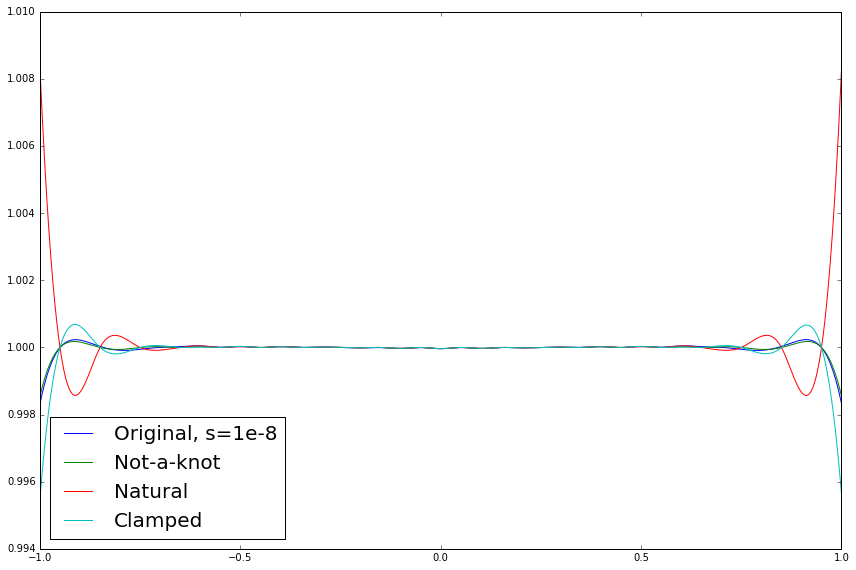

In [82]:
from scipy import interpolate

nSampleCBP = 5            # number of CBP spots per chip
plot = True


samples = (np.arange(len(ib))%nPerCCD)%(nPerCCD//nSampleCBP) == (nPerCCD//nSampleCBP)//2  # Where we take CBP data

interpCalS_original = interpolate.InterpolatedUnivariateSpline(ib[samples], calS[samples], k=3)  # spline fit to CBP data
interpCalS_knot     = interpolate.CubicSpline(ib[samples], calS[samples], bc_type='not-a-knot')  # spline fit to CBP data
interpCalS_natural  = interpolate.CubicSpline(ib[samples], calS[samples], bc_type='natural')  # spline fit to CBP data
interpCalS_clamped  = interpolate.CubicSpline(ib[samples], calS[samples], bc_type='clamped')  # spline fit to CBP data


rawEstIllum_original = Fb/interpCalS_original(ib)   # raw estimated illumination
rawEstIllum_knot     = Fb/interpCalS_knot(ib)   # raw estimated illumination
rawEstIllum_natural  = Fb/interpCalS_natural(ib)   # raw estimated illumination
rawEstIllum_clamped  = Fb/interpCalS_clamped(ib)   # raw estimated illumination


interpIllum_original = interpolate.UnivariateSpline(ib[samples], rawEstIllum[samples], s=1e-8)
interpIllum_knot     = interpolate.CubicSpline(ib[samples], rawEstIllum[samples], bc_type='not-a-knot')
interpIllum_natural  = interpolate.CubicSpline(ib[samples], rawEstIllum[samples], bc_type='natural')
interpIllum_clamped  = interpolate.CubicSpline(ib[samples], rawEstIllum[samples], bc_type='clamped')


estCalS_original = Fb/interpIllum_original(ib)
estCalS_knot     = Fb/interpIllum_knot(ib)
estCalS_natural  = Fb/interpIllum_natural(ib)
estCalS_clamped  = Fb/interpIllum_clamped(ib)

residual_original = estCalS_original/calS
residual_knot     = estCalS_knot/calS
residual_natural  = estCalS_natural/calS
residual_clamped  = estCalS_clamped/calS

peak_to_peak_original = np.max(residual_original) - np.min(residual_original)
peak_to_peak_knot     = np.max(residual_knot) - np.min(residual_knot)
peak_to_peak_natural  = np.max(residual_natural) - np.min(residual_natural)
peak_to_peak_clamped  = np.max(residual_clamped) - np.min(residual_clamped)

# maxval = np.max(residual)
# print maxval

# print 'Ringing = %.3f / 1000' %(peak_to_peak*1000)
# print 'Max val = %.3f / 1000' %(1000*maxval-1000)
res_multiplier = 1

if plot:
    plt.figure(figsize=(12,8))
    plt.plot(ib, res_multiplier*residual_original-res_multiplier+1, '-', label='Original, s=1e-8')
    plt.plot(ib, res_multiplier*residual_knot-res_multiplier+1,     '-', label='Not-a-knot')
    plt.plot(ib, res_multiplier*residual_natural-res_multiplier+1,  '-', label='Natural')
    plt.plot(ib, res_multiplier*residual_clamped-res_multiplier+1,  '-', label='Clamped')

    plt.legend(loc='lower left',  fontsize=20, ncol=1)
#     foo = plt.ylim(0.5, 1.35)
    plt.tight_layout()
    plt.savefig(os.path.join(dirName, "residuals_3.png"))